<a href="https://colab.research.google.com/github/MojTabaa4/POS-Tagging-and-Named-Entity-Recognition-with-RNNs/blob/main/POS_NER_with_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

In [2]:
import os
import random
import time
from collections import Counter, defaultdict
from typing import List, Tuple

import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from gensim.models import KeyedVectors, Word2Vec
from keras.layers import (GRU, LSTM, RNN, Bidirectional, Dense, Dropout,
                          Embedding, Input, Masking, SimpleRNN,
                          SpatialDropout1D, TimeDistributed)
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk.corpus import treebank
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from sklearn.model_selection import train_test_split
from tensorflow.keras import *
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


# PTBPosLoader Class

The `PTBPosLoader` class is designed for loading and preprocessing the Penn Treebank Part of Speech (POS) dataset. It provides functionality to split the dataset into training, validation, and testing sets, as well as extract word-tag pairs from these sets. The class also offers methods to retrieve the vocabulary and tag set of the training set, as well as access to the individual sets.


In [3]:
class PTBPosLoader:
    """
    A class for loading and preprocessing the Penn Treebank Part of Speech dataset.
    """

    def __init__(self, use_universal_tag_set: bool = True, test_size: float = 0.1, val_size: float = 0.1):
        """
        Initializes the PTBPosLoader object.

        Args:
            use_universal_tag_set (bool): Whether to use the universal tag set. Default is True.
            test_size (float): The proportion of the dataset to use for testing. Default is 0.1.
            val_size (float): The proportion of the training set to use for validation. Default is 0.1.
        """
        if use_universal_tag_set:
            self.ptb = list(treebank.tagged_sents(tagset='universal'))
        else:
            self.ptb = list(treebank.tagged_sents())

        self.test_size = test_size
        self.val_size = val_size
        self._split_train_val_test_sets()
        self._extract_all_word_tag_pairs()

    def _split_train_val_test_sets(self) -> None:
        """
        Splits the dataset into training, validation, and testing sets.
        """
        self.train_set, self.test_set = train_test_split(self.ptb,
                                                         test_size=self.test_size,
                                                         random_state=100)
        self.train_set, self.val_set = train_test_split(self.train_set,
                                                        test_size=self.val_size,
                                                        random_state=100)

    def _extract_all_word_tag_pairs(self) -> None:
        """
        Extracts all word-tag pairs from the training, validation, and testing sets.
        """
        self.train_word_tag_pairs = [word_tag for record in self.train_set for word_tag in record]
        self.val_word_tag_pairs = [word_tag for record in self.val_set for word_tag in record]
        self.test_word_tag_pairs = [word_tag for record in self.test_set for word_tag in record]

    def get_vocab_and_tags_set(self) -> Tuple[set, List[str]]:
        """
        Returns a tuple containing the vocabulary and tags set of the training set.

        Returns:
            A tuple containing the vocabulary (set) and tag set (list of strings) of the training set.
        """
        vocab = set([word_tag[0] for word_tag in self.train_word_tag_pairs])
        tags_set = sorted(list(set([pair[1] for pair in self.train_word_tag_pairs])))

        return vocab, tags_set

    def get_train_val_test_sets(self) -> Tuple[
        List[List[Tuple[str, str]]], List[List[Tuple[str, str]]], List[List[Tuple[str, str]]]]:
        """
        Returns a tuple containing the training, validation, and testing sets.

        Returns:
            A tuple containing the training, validation, and testing sets, each as a list of sentences, where each sentence
            is a list of word-tag pairs (tuples).
        """
        return self.train_set, self.val_set, self.test_set


In [4]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

## Exploring the PTB POS Dataset

I have written some code to explore the Penn Treebank Part of Speech (POS) dataset using the `PTBPosLoader` class.

Number of examples in train and test sets combined: 3561
Number of examples in train set: 3169
Number of examples in test set: 392
[('One', 'NUM'), ('clear', 'ADJ'), ('sign', 'NOUN'), ('of', 'ADP'), ('Japan', 'NOUN'), ("'s", 'PRT'), ('nervousness', 'NOUN'), ('came', 'VERB'), ('this', 'DET'), ('week', 'NOUN'), (',', '.'), ('when', 'ADV'), ('a', 'DET'), ('spokesman', 'NOUN'), ('for', 'ADP'), ('Japan', 'NOUN'), ("'s", 'PRT'), ('Foreign', 'NOUN'), ('Ministry', 'NOUN'), ('devoted', 'VERB'), ('nearly', 'ADV'), ('all', 'DET'), ('of', 'ADP'), ('a', 'DET'), ('regular', 'ADJ'), (',', '.'), ('half-hour', 'ADJ'), ('briefing', 'NOUN'), ('for', 'ADP'), ('foreign', 'ADJ'), ('journalists', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('subject', 'NOUN'), ('of', 'ADP'), ('recent', 'ADJ'), ('Japanese', 'ADJ'), ('investments', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('*T*-1', 'X'), ('.', '.')]
[('Buying', 'VERB'), ('for', 'ADP'), ('the', 'DET'), ('most', 'ADJ'), ('part', 'NOUN'), ('carried',

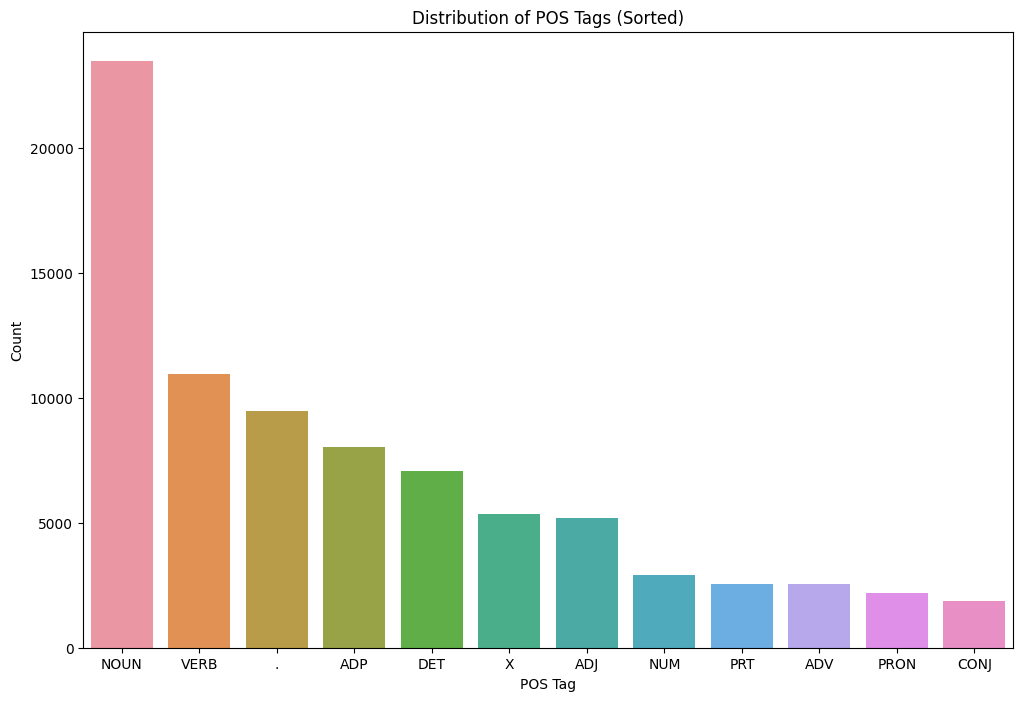

In [5]:
loader = PTBPosLoader()
train, val, test = loader.get_train_val_test_sets()

print("Number of examples in train and test sets combined:", len(train) + len(test))
print("Number of examples in train set:", len(train))
print("Number of examples in test set:", len(test))

print(train[1])
print(test[1])

vocab, tag_set = loader.get_vocab_and_tags_set()
print("Vocabulary size:", len(vocab))
print("Number of unique POS tags:", len(tag_set))

tag_counts = {tag: 0 for tag in tag_set}

train_word_tag_pairs = [word_tag for sentence in loader.train_set for word_tag in sentence]
tag_counts = Counter(tag for word, tag in train_word_tag_pairs)

sorted_tag_counts = {k: v for k, v in sorted(tag_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(12, 8))
sns.barplot(x=list(sorted_tag_counts.keys()), y=list(sorted_tag_counts.values()))
plt.xlabel("POS Tag")
plt.ylabel("Count")
plt.title("Distribution of POS Tags (Sorted)")
plt.show()

# Implement Viterbi Algorithm

# POSTagger Class

I created this class called `POSTagger` to perform part-of-speech tagging using the Viterbi algorithm. The class takes in an instance of the `PTBPosLoader` class.

The `POSTagger` class has several methods for setting up and performing the tagging. The `set_transition_matrix` method sets up the transition matrix based on the training set, and the `set_emission_matrix` method sets up the emission matrix based on the training set or a saved matrix. The `apply_viterbi` method applies the Viterbi algorithm for tagging, and the `evaluate` method evaluates the accuracy of the tagging results.

The class also has methods for calculating the transition probability and emission probability. The `get_transition` method calculates the transition probability between two tags, and the `get_emission` method calculates the emission probability of a word given a tag.

The `POSTagger` class also has a `smoothing_const` parameter for handling out-of-vocabulary words, and a `print_transition_matrix` and `print_emission_matrix` parameter for printing the transition and emission matrices, respectively.


In [6]:
class POSTagger:
    def __init__(self, dataset_loader: PTBPosLoader, smoothing_const: float = 0.001) -> None:
        """
        Initialize the POSTagger.

        Args:
            dataset_loader: An instance of PTBPosLoader for loading the dataset.
            smoothing_const: Smoothing constant for handling out-of-vocabulary words.
        """
        self.dataset_loader = dataset_loader
        self.smoothing_const = smoothing_const
        self.emission_file_name = 'emission_probs.csv'

        self.train_set, self.val_set, self.test_set = self.dataset_loader.get_train_val_test_sets()
        self.all_tags = [pair[1] for pair in self.dataset_loader.train_word_tag_pairs]

        self.vocab, self.tags_set = self.dataset_loader.get_vocab_and_tags_set()

        self.test_run_base: List[Tuple[str, str]] = [tup for sent in self.test_set for tup in sent]
        self.test_tagged_words: List[str] = [tup[0] for sent in self.test_set for tup in sent]

        self.tags_matrix: np.ndarray = None
        self.trans_df: pd.DataFrame = None
        self.emission_matrix: np.ndarray = None
        self.emission_df: pd.DataFrame = None

    def get_transition(self, curr_tag: str, prev_tag: str) -> float:
        """
        Calculate the transition probability between two tags.

        Args:
            curr_tag: Current tag.
            prev_tag: Previous tag.

        Returns:
            Transition probability from prev_tag to curr_tag.
        """
        prev_tag_count = len([tag for tag in self.all_tags if tag == prev_tag])
        prev_tag_curr_tag_count = sum(
            1 for i in range(len(self.all_tags) - 1)
            if self.all_tags[i + 1] == curr_tag and self.all_tags[i] == prev_tag
        )

        return prev_tag_curr_tag_count / prev_tag_count

    def set_transition_matrix(self, print_transition_matrix: bool = False) -> None:
        """
        Set the transition matrix based on the training set.

        Args:
            print_transition_matrix: Whether to print the transition matrix.
        """
        self.tags_matrix = np.zeros((len(self.tags_set), len(self.tags_set)), dtype='float32')

        with tqdm(total=len(self.tags_set) ** 2, desc="Populating transition matrix") as pbar:
            for i, prev_tag in enumerate(list(self.tags_set)):
                for j, curr_tag in enumerate(list(self.tags_set)):
                    self.tags_matrix[i, j] = self.get_transition(curr_tag, prev_tag)
                    pbar.update(1)

        self.trans_df = pd.DataFrame(self.tags_matrix, columns=list(self.tags_set), index=list(self.tags_set))

        if print_transition_matrix:
            print(self.trans_df)

    def get_emission(self, word: str, tag: str) -> float:
        """
        Calculate the emission probability of a word given a tag.

        Args:
            word: Word.
            tag: Tag.

        Returns:
            Emission probability of the word given the tag.
        """
        pairs_with_tag = [pair for pair in self.dataset_loader.train_word_tag_pairs if pair[1] == tag]
        words_with_tag = [pair[0] for pair in pairs_with_tag if pair[0] == word[0]]

        return len(words_with_tag) / len(pairs_with_tag)

    def set_emission_matrix(self, print_emission_matrix: bool = False) -> None:
        """
        Set the emission matrix based on the training or saved matrix.

        Args:
            print_emission_matrix: Whether to print the emission matrix.
        """
        if os.path.exists(self.emission_file_name):
            self.read_emission_csv()
        else:
            num_word_tag_pairs = len(self.dataset_loader.test_word_tag_pairs)
            self.emission_matrix = np.zeros((num_word_tag_pairs, len(self.tags_set)),
                                            dtype='float32')
            word_tag_pairs = list(self.dataset_loader.test_word_tag_pairs)

            with tqdm(total=num_word_tag_pairs, desc="Populating emission matrix") as pbar:
                for i, word in enumerate(word_tag_pairs):
                    for j, tag in enumerate(list(self.tags_set)):
                        self.emission_matrix[i, j] = self.get_emission(word, tag)
                    pbar.update(1)

            self.emission_df = pd.DataFrame(self.emission_matrix, columns=list(self.tags_set),
                                            index=list(self.dataset_loader.test_word_tag_pairs))
            self.save_emission_csv()

        if print_emission_matrix:
            print(self.emission_df)

    def save_emission_csv(self) -> None:
        """Save the emission matrix to a CSV file."""
        self.emission_df.to_csv(self.emission_file_name, index=list(self.dataset_loader.test_word_tag_pairs))

    def read_emission_csv(self) -> None:
        """Read the emission matrix from a CSV file."""
        self.emission_df = pd.read_csv(self.emission_file_name).set_index('Unnamed: 0')

    def _viterbi(self) -> List[Tuple[str, str]]:
        """
        Perform the Viterbi algorithm for tagging.

        Returns:
            List of tuples containing word-tag pairs.
        """
        viterbi = []
        for key, word in enumerate(self.test_tagged_words):
            max_prob = -1
            best_tag = None

            for tag in self.tags_set:
                if key == 0:
                    transition_p = self.trans_df.loc['.', tag]
                else:
                    last_state = viterbi[-1]
                    transition_p = self.trans_df.loc[last_state, tag]

                emission_p = self.emission_df.iat[key, self.tags_set.index(tag)]

                prob = emission_p * transition_p

                if prob >= max_prob:
                    max_prob = prob
                    best_tag = tag

            viterbi.append(best_tag)

        return list(zip(self.test_tagged_words, viterbi))

    def smoothed_viterbi(self) -> List[Tuple[str, str]]:
        """
        Perform the Viterbi algorithm with smoothing for tagging.

        Returns:
            List of tuples containing word-tag pairs.
        """
        viterbi = []

        for key, word in enumerate(self.test_tagged_words):
            max_prob = -1
            best_tag = None
            for tag in self.tags_set:
                if key == 0:
                    transition_p = self.trans_df.loc['.', tag]
                else:
                    last_state = viterbi[-1]
                    transition_p = self.trans_df.loc[last_state, tag]

                if word in self.vocab:
                    emission_p = self.emission_df.iat[key, self.tags_set.index(tag)]
                else:
                    emission_p = self.smoothing_const

                prob = emission_p * transition_p

                if prob >= max_prob:
                    max_prob = prob
                    best_tag = tag

            viterbi.append(best_tag)

        return list(zip(self.test_tagged_words, viterbi))

    def apply_viterbi(self, smoothing: bool = True) -> List[Tuple[str, str]]:
        """
        Apply the Viterbi algorithm for tagging.

        Args:
            smoothing: Whether to use smoothing during tagging.

        Returns:
            List of tuples containing word-tag pairs.
        """
        self.set_transition_matrix()
        self.set_emission_matrix()

        if smoothing:
            tagged_res = self.smoothed_viterbi()
        else:
            tagged_res = self._viterbi()

        return tagged_res

    def evaluate(self, tagged_results: List[Tuple[str, str]]) -> Tuple[float, List[Tuple[str, str]]]:
        """
        Evaluate the accuracy of the tagging results.

        Args:
            tagged_results: List of tuples containing word-tag pairs.

        Returns:
            Tuple of accuracy and a list of wrong predictions.
        """
        correct_predictions = []
        wrong_predictions = []

        for predicted, actual in zip(tagged_results, self.test_run_base):
            if predicted == actual:
                correct_predictions.append(predicted)
            else:
                wrong_predictions.append((predicted, actual))

        accuracy = len(correct_predictions) / len(tagged_results)

        return accuracy, wrong_predictions


In [7]:
ptb_loader = PTBPosLoader()
pos_tagger = POSTagger(ptb_loader)

viterbi_tag_res = pos_tagger.apply_viterbi()

accuracy, wrong_preds = pos_tagger.evaluate(viterbi_tag_res)

print(f"accuracy = {accuracy}")

for i in range(10):
    print(f"word: {wrong_preds[i][0][0]} | predicted: {wrong_preds[i][0][1]} | expected: {wrong_preds[i][1][1]}")


Populating transition matrix: 100%|██████████| 144/144 [00:05<00:00, 28.74it/s]


accuracy = 0.9325159695034
word: book | predicted: NOUN | expected: VERB
word: stocks | predicted: NOUN | expected: ADV
word: up | predicted: PRT | expected: ADP
word: fractionally | predicted: VERB | expected: ADV
word: over | predicted: ADP | expected: PRT
word: mine | predicted: NOUN | expected: ADJ
word: Palestinian | predicted: ADJ | expected: NOUN
word: first | predicted: ADJ | expected: ADV
word: clamped | predicted: X | expected: VERB
word: ankle | predicted: VERB | expected: NOUN


# RecurrentPOSTagger Class for POS Tagging with Recurrent Neural Network

The `RecurrentPOSTagger` class is a Python class that can be used to perform part-of-speech (POS) tagging using a recurrent neural network. 

Upon initialization, the class loads the Penn Treebank dataset and prepares the data for training and testing. It tokenizes the sentences, applies padding to make them of equal length, and encodes the words and tags as integers.

The class provides methods for creating and fitting a recurrent neural network model for POS tagging. The `make_model` method creates the model with the specified recurrent layer type (RNN, LSTM, or GRU), number of units in the recurrent layer, and embedding size. The `fit_model` method trains the model on the training data and evaluates it on the validation or test data, depending on the `test_data` flag.

The `RecurrentPOSTagger` class also provides properties for getting the number of unique words and tags in the training, validation, and test data.

In [8]:
class RecurrentPOSTagger:
    def __init__(self) -> None:
        """
        Initializes the RecurrentPOSTagger class.
        """
        data_loader = PTBPosLoader()
        self.train_set, self.val_set, self.test_set = data_loader.get_train_val_test_sets()
        self.vocab, self.tag_set = data_loader.get_vocab_and_tags_set()
        self.vocab_size = len(self.vocab)

        self._prepare_data()
        # self.prepare_xy()

    def _prepare_data(self) -> None:
        """
        Helper method to prepare the data.
        """

        def get_XY(dataset: List[List[Tuple[str, str]]]) -> Tuple[List[List[str]], List[List[str]]]:
            X = []
            Y = []

            for sentence in dataset:
                X_sentence, Y_sentence = zip(*sentence)
                X.append(list(X_sentence))
                Y.append(list(Y_sentence))

            return X, Y

        self.X, self.Y = get_XY(self.train_set)
        self.X_val, self.Y_val = get_XY(self.val_set)
        self.X_test, self.Y_test = get_XY(self.test_set)

    def _initialize_tokenizer(self, data: List[List[str]]) -> List[List[int]]:
        """
        Initializes a tokenizer and encodes the data.

        Args:
            data: List of sentences.

        Returns:
            Encoded data.
        """
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(data)
        encoded = tokenizer.texts_to_sequences(data)

        return encoded

    def _apply_padding(self, tokenized_x: List[List[int]], tokenized_y: List[List[int]]) -> Tuple[
        List[List[int]], List[List[int]]]:
        """
        Applies padding to the tokenized data.

        Args:
            tokenized_x: Tokenized input data.
            tokenized_y: Tokenized target data.

        Returns:
            Padded input and target data.
        """
        pad_x = pad_sequences(tokenized_x, maxlen=self.max_length, padding="pre", truncating="post")
        pad_y = pad_sequences(tokenized_y, maxlen=self.max_length, padding="pre", truncating="post")

        return pad_x, pad_y

    def prepare_xy(self, padding_max_length: int = 100) -> None:
        """
        Prepares the input and target data.

        Args:
            padding_max_length: Maximum length for padding.

        Returns:
            None
        """
        self.max_length = padding_max_length

        tokenized_X = self._initialize_tokenizer(self.X)
        tokenized_X_val = self._initialize_tokenizer(self.X_val)
        tokenized_X_test = self._initialize_tokenizer(self.X_test)

        tokenized_Y = self._initialize_tokenizer(self.Y)
        tokenized_Y_val = self._initialize_tokenizer(self.Y_val)
        tokenized_Y_test = self._initialize_tokenizer(self.Y_test)

        self.X, self.Y = self._apply_padding(tokenized_X, tokenized_Y)
        self.X_val, self.Y_val = self._apply_padding(tokenized_X_val, tokenized_Y_val)
        self.X_test, self.Y_test = self._apply_padding(tokenized_X_test, tokenized_Y_test)

        self.Y, self.Y_val, self.Y_test = to_categorical(self.Y), to_categorical(self.Y_val), to_categorical(
            self.Y_test)
        self.num_classes = self.Y.shape[2]

    def make_model(self, layer_type: str = "RNN", num_of_units: int = 128, embedding_size: int = 300) -> None:
        """
        Creates the recurrent model.

        Args:
            layer_type: Type of recurrent layer (RNN, LSTM, GRU).
            num_of_units: Number of units in the recurrent layer.
            embedding_size: Size of the embedding layer.

        Returns:
            None
        """
        self.rnn_model = Sequential()
        self.rnn_model.add(
            Embedding(input_dim=self.vocab_size,
                      output_dim=embedding_size,
                      input_length=self.max_length,
                      trainable=False)
        )

        if layer_type == "RNN":
            self.rnn_model.add(SimpleRNN(num_of_units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
        elif layer_type == "LSTM":
            self.rnn_model.add(LSTM(num_of_units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
        elif layer_type == "GRU":
            self.rnn_model.add(GRU(num_of_units, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

        self.rnn_model.add(TimeDistributed(Dense(self.num_classes, activation='softmax')))

        self.rnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
        print(self.rnn_model.summary())

    def fit_model(self, test_data: bool = False, batch_size: int = 32, epochs: int = 10) -> History:
        """
        Fits the model to the training data.

        Args:
            test_data: Flag indicating whether to use test data for validation.
            batch_size: Batch size for training.
            epochs: Number of epochs for training.

        Returns:
            Training history.
        """
        if test_data:
            rnn_training = self.rnn_model.fit(self.X, self.Y, batch_size=batch_size, epochs=epochs,
                                              validation_data=(self.X_test, self.Y_test))
        else:
            rnn_training = self.rnn_model.fit(self.X, self.Y, batch_size=batch_size, epochs=epochs,
                                              validation_data=(self.X_val, self.Y_val))

        return rnn_training

    @property
    def num_words(self) -> int:
        """
        Returns the number of unique words in the training data.

        Returns:
            Number of unique words.
        """
        return len(set([word.lower() for sentence in self.X for word in sentence]))

    @property
    def num_tags(self) -> int:
        """
        Returns the number of unique tags in the training data.

        Returns:
            Number of unique tags.
        """
        return len(set([word.lower() for sentence in self.Y for word in sentence]))

    @property
    def num_words_val(self) -> int:
        """
        Returns the number of unique words in the validation data.

        Returns:
            Number of unique words.
        """
        return len(set([word.lower() for sentence in self.X_val for word in sentence]))

    @property
    def num_tags_val(self) -> int:
        """
        Returns the number of unique tags in the validation data.

        Returns:
            Number of unique tags.
        """
        return len(set([word.lower() for sentence in self.Y_val for word in sentence]))

    @property
    def num_words_test(self) -> int:
        """
        Returns the number of unique words in the test data.

        Returns:
            Number of unique words.
        """
        return len(set([word.lower() for sentence in self.X_test for word in sentence]))

    @property
    def num_tags_test(self) -> int:
        """
        Returns the number of unique tags in the test data.

        Returns:
            Number of unique tags.
        """
        return len(set([word.lower() for sentence in self.Y_test for word in sentence]))


## Evaluate different models
I wrote this code to train and evaluate different models for part-of-speech (POS) tagging using the Penn Treebank dataset. The code uses the `RecurrentPOSTagger` class to prepare the data, create and fit the model, and evaluate the accuracy on the test data.

The `plot` function is used to plot the accuracies of different values for batch size, padding max length, or embedding size. The `train_and_evaluate_model` function trains and evaluates a specified model with given parameters.

The `plot_parameters` function is used to plot the accuracy of different parameter values for batch size, padding max length, and embedding size for each model type specified in the `models` list. 

The code uses a loop to train and evaluate the model with different parameter values, and then plots the accuracies for each value. 

<ipython-input-10-359270ca8de6>:58: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


MODEL:  LSTM


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1113300   
                                                                 
 lstm_1 (LSTM)               (None, 100, 128)          117248    
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 1,232,225
Trainable params: 118,925
Non-trainable params: 1,113,300
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 65s 545ms/step - loss: 0.9820 - accuracy: 0.7634 - val_loss: 0.7165 - val_accuracy: 0.8007
Epoch 2/15
100/100 [==============================] - 40s 402ms/step - loss: 0.6326 - 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 200)          2226600   
                                                                 
 lstm_2 (LSTM)               (None, 100, 128)          168448    
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 2,396,725
Trainable params: 170,125
Non-trainable params: 2,226,600
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 42s 383ms/step - loss: 0.8758 - accuracy: 0.7762 - val_loss: 0.6436 - val_accuracy: 0.8005
Epoch 2/15
100/100 [==============================] - 38s 381ms/step - loss: 0.5973 - 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 300)          3339900   
                                                                 
 lstm_3 (LSTM)               (None, 100, 128)          219648    
                                                                 
 time_distributed_3 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 3,561,225
Trainable params: 221,325
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 43s 397ms/step - loss: 0.8324 - accuracy: 0.7791 - val_loss: 0.6354 - val_accuracy: 0.8008
Epoch 2/15
100/100 [==============================] - 39s 393ms/step - loss: 0.5749 - 

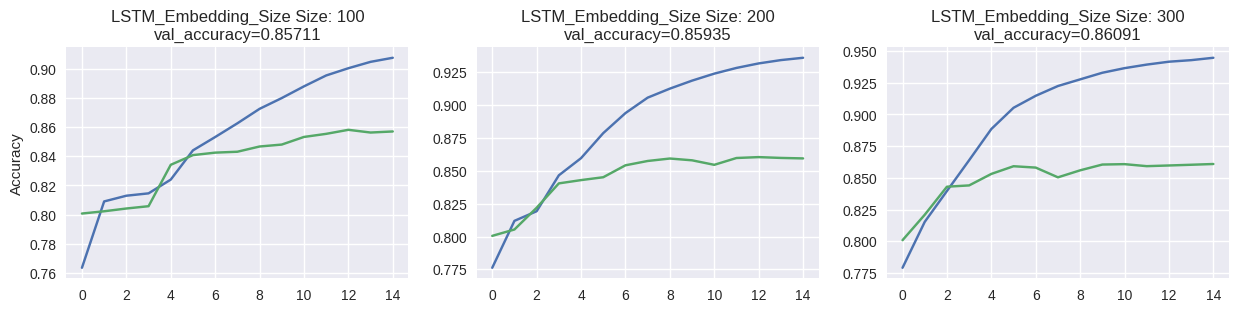

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 300)           3339900   
                                                                 
 lstm_4 (LSTM)               (None, 50, 128)           219648    
                                                                 
 time_distributed_4 (TimeDis  (None, 50, 13)           1677      
 tributed)                                                       
                                                                 
Total params: 3,561,225
Trainable params: 221,325
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 23s 197ms/step - loss: 1.3635 - accuracy: 0.5971 - val_loss: 1.1688 - val_accuracy: 0.6223
Epoch 2/15
100/100 [==============================] - 20s 201ms/step - loss: 1.0093 - 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          3339900   
                                                                 
 lstm_5 (LSTM)               (None, 100, 128)          219648    
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 3,561,225
Trainable params: 221,325
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 42s 394ms/step - loss: 0.8566 - accuracy: 0.7768 - val_loss: 0.6320 - val_accuracy: 0.8011
Epoch 2/15
100/100 [==============================] - 39s 390ms/step - loss: 0.5767 - 

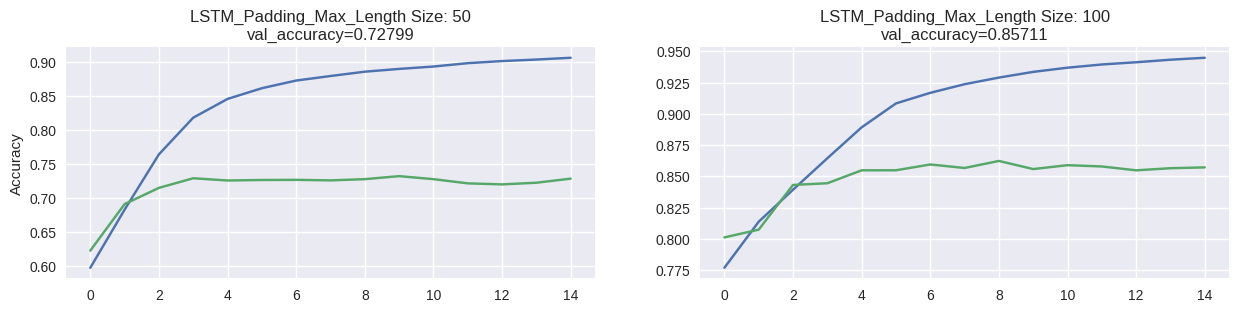

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          3339900   
                                                                 
 lstm_6 (LSTM)               (None, 100, 128)          219648    
                                                                 
 time_distributed_6 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 3,561,225
Trainable params: 221,325
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
199/199 [==============================] - 82s 400ms/step - loss: 0.7113 - accuracy: 0.7974 - val_loss: 0.5731 - val_accuracy: 0.8248
Epoch 2/15
199/199 [==============================] - 80s 402ms/step - loss: 0.4722 - 

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 300)          3339900   
                                                                 
 lstm_7 (LSTM)               (None, 100, 128)          219648    
                                                                 
 time_distributed_7 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 3,561,225
Trainable params: 221,325
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 42s 391ms/step - loss: 0.8504 - accuracy: 0.7784 - val_loss: 0.6282 - val_accuracy: 0.8014
Epoch 2/15
100/100 [==============================] - 40s 404ms/step - loss: 0.5678 - 

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 300)          3339900   
                                                                 
 lstm_8 (LSTM)               (None, 100, 128)          219648    
                                                                 
 time_distributed_8 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 3,561,225
Trainable params: 221,325
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
50/50 [==============================] - 23s 396ms/step - loss: 1.0040 - accuracy: 0.7497 - val_loss: 0.6942 - val_accuracy: 0.7975
Epoch 2/15
50/50 [==============================] - 20s 399ms/step - loss: 0.6277 - accu

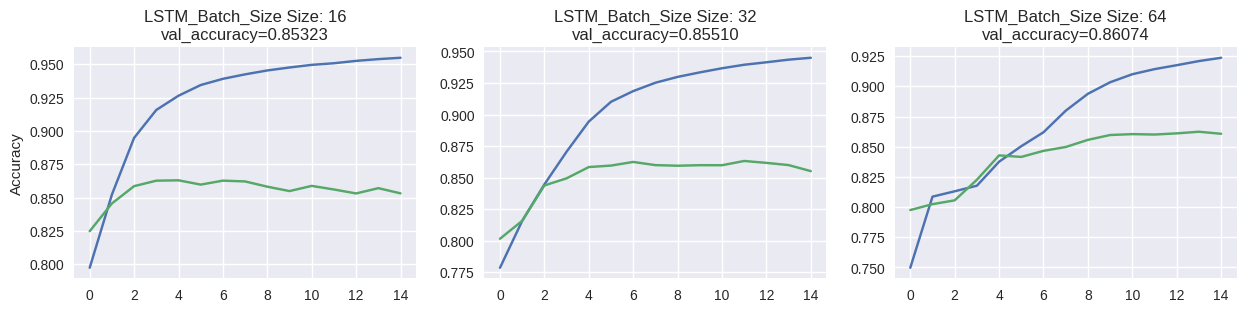

MODEL:  GRU


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          1113300   
                                                                 
 gru (GRU)                   (None, 100, 128)          88320     
                                                                 
 time_distributed_9 (TimeDis  (None, 100, 13)          1677      
 tributed)                                                       
                                                                 
Total params: 1,203,297
Trainable params: 89,997
Non-trainable params: 1,113,300
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 38s 352ms/step - loss: 0.9799 - accuracy: 0.7452 - val_loss: 0.6746 - val_accuracy: 0.7997
Epoch 2/15
100/100 [==============================] - 35s 350ms/step - loss: 0.5949 - a

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 200)          2226600   
                                                                 
 gru_1 (GRU)                 (None, 100, 128)          126720    
                                                                 
 time_distributed_10 (TimeDi  (None, 100, 13)          1677      
 stributed)                                                      
                                                                 
Total params: 2,354,997
Trainable params: 128,397
Non-trainable params: 2,226,600
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 40s 363ms/step - loss: 0.8573 - accuracy: 0.7619 - val_loss: 0.6169 - val_accuracy: 0.8056
Epoch 2/15
100/100 [==============================] - 37s 368ms/step - loss: 0.5568 -

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 300)          3339900   
                                                                 
 gru_2 (GRU)                 (None, 100, 128)          165120    
                                                                 
 time_distributed_11 (TimeDi  (None, 100, 13)          1677      
 stributed)                                                      
                                                                 
Total params: 3,506,697
Trainable params: 166,797
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 39s 358ms/step - loss: 0.8358 - accuracy: 0.7658 - val_loss: 0.6004 - val_accuracy: 0.8056
Epoch 2/15
100/100 [==============================] - 36s 360ms/step - loss: 0.5118 -

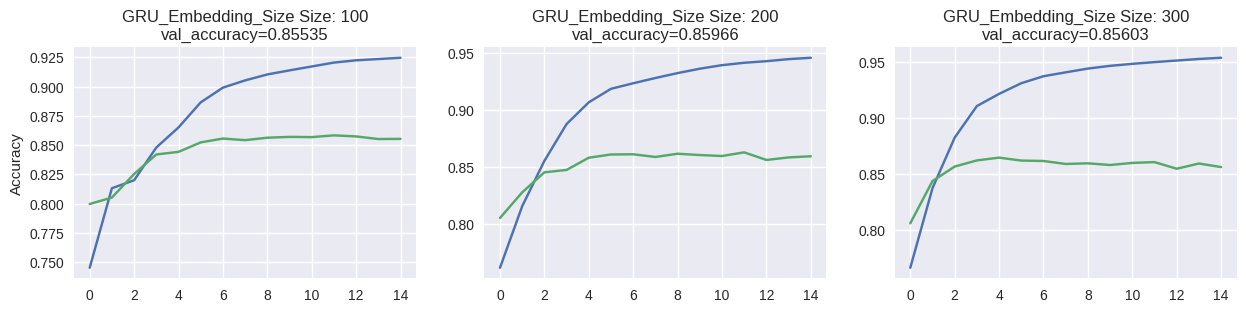

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 300)           3339900   
                                                                 
 gru_3 (GRU)                 (None, 50, 128)           165120    
                                                                 
 time_distributed_12 (TimeDi  (None, 50, 13)           1677      
 stributed)                                                      
                                                                 
Total params: 3,506,697
Trainable params: 166,797
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 21s 179ms/step - loss: 1.3097 - accuracy: 0.5992 - val_loss: 1.0667 - val_accuracy: 0.6721
Epoch 2/15
100/100 [==============================] - 18s 183ms/step - loss: 0.8138 -

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 300)          3339900   
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          165120    
                                                                 
 time_distributed_13 (TimeDi  (None, 100, 13)          1677      
 stributed)                                                      
                                                                 
Total params: 3,506,697
Trainable params: 166,797
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 38s 352ms/step - loss: 0.8295 - accuracy: 0.7660 - val_loss: 0.6025 - val_accuracy: 0.8057
Epoch 2/15
100/100 [==============================] - 35s 348ms/step - loss: 0.5156 -

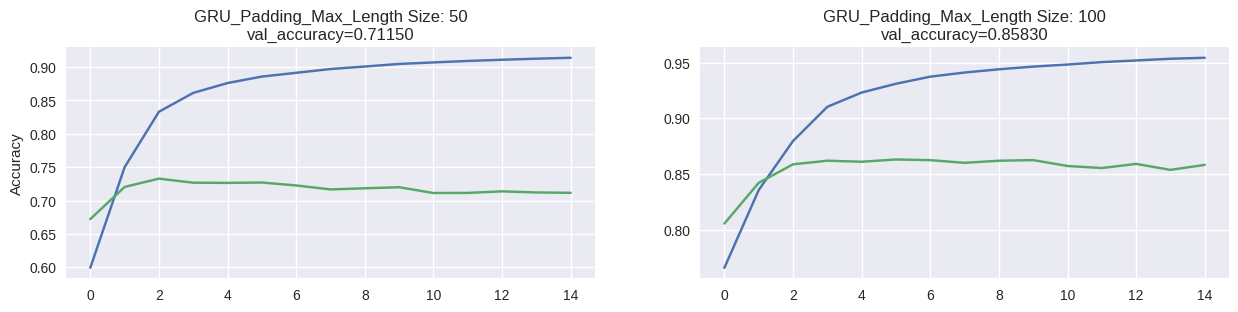

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 300)          3339900   
                                                                 
 gru_5 (GRU)                 (None, 100, 128)          165120    
                                                                 
 time_distributed_14 (TimeDi  (None, 100, 13)          1677      
 stributed)                                                      
                                                                 
Total params: 3,506,697
Trainable params: 166,797
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
199/199 [==============================] - 74s 358ms/step - loss: 0.6839 - accuracy: 0.7970 - val_loss: 0.5205 - val_accuracy: 0.8428
Epoch 2/15
199/199 [==============================] - 70s 350ms/step - loss: 0.3658 -

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 300)          3339900   
                                                                 
 gru_6 (GRU)                 (None, 100, 128)          165120    
                                                                 
 time_distributed_15 (TimeDi  (None, 100, 13)          1677      
 stributed)                                                      
                                                                 
Total params: 3,506,697
Trainable params: 166,797
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
100/100 [==============================] - 39s 356ms/step - loss: 0.8218 - accuracy: 0.7671 - val_loss: 0.5990 - val_accuracy: 0.8061
Epoch 2/15
100/100 [==============================] - 35s 354ms/step - loss: 0.5146 -

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 100, 300)          3339900   
                                                                 
 gru_7 (GRU)                 (None, 100, 128)          165120    
                                                                 
 time_distributed_16 (TimeDi  (None, 100, 13)          1677      
 stributed)                                                      
                                                                 
Total params: 3,506,697
Trainable params: 166,797
Non-trainable params: 3,339,900
_________________________________________________________________
None
Epoch 1/15
50/50 [==============================] - 21s 373ms/step - loss: 1.0321 - accuracy: 0.7302 - val_loss: 0.7051 - val_accuracy: 0.7453
Epoch 2/15
50/50 [==============================] - 17s 342ms/step - loss: 0.6215 - acc

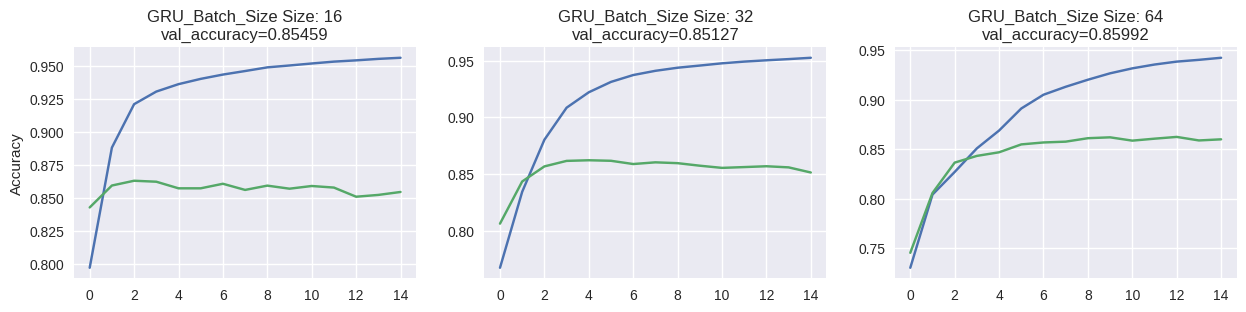

In [10]:
def plot(values: List[int], accuracies, topic: str) -> None:
    """
    Plots the accuracies of different values.

    Args:
        values (List[int]): The values for the x-axis.
        accuracies (Dict[int, Any]): A dictionary of accuracies.
            The keys represent the index of the accuracy data, and the values represent the accuracy history.
        topic (str): The topic of the plot.

    Returns:
        None
    """
    fig, ax = plt.subplots(nrows=1, ncols=len(values))
    fig.set_figheight(3)
    fig.set_figwidth(15)

    for i in range(len(values)):
        ax[i].plot(accuracies[i].history["accuracy"], label="Train")
        ax[i].plot(accuracies[i].history["val_accuracy"], label="Test")
        ax[i].set_title(
            f'{topic} Size: {values[i]}\nval_accuracy={accuracies[i].history["val_accuracy"][-1]:.5f}'
        )
        ax[0].set_ylabel("Accuracy")

    plt.show()
    fig.savefig(f"{topic}.png")


def train_and_evaluate_model(
        model: str, batch_size: int, padding_max_length: int, num_of_units: int,
        embedding_size: int, epochs: int
):
    """
    Trains and evaluates a model.

    Returns:
        Any: The history object returned by the model training.
    """
    rnn_model = RecurrentPOSTagger()

    rnn_model.prepare_xy(padding_max_length=padding_max_length)

    rnn_model.make_model(layer_type=model, num_of_units=num_of_units, embedding_size=embedding_size)
    
    history = rnn_model.fit_model(batch_size=batch_size, epochs=epochs)

    return history


def plot_parameters(models: List[str]) -> None:
    """
    Plots the parameters for different models.

    Args:
        models (List[str]): A list of model types to plot.
    """
    plt.style.use('seaborn')

    batch_sizes = [16, 32, 64]
    pad_max_lengths = [50, 100]
    embedding_sizes = [100, 200, 300]

    for model in models:
        print("MODEL: ", model)
        batch_accuracies = dict()
        max_len_accuracies = dict()
        embedding_size_accuracy = dict()

        for i, embedding_size in enumerate(embedding_sizes):
            history = train_and_evaluate_model(
                model, batch_size=32, padding_max_length=100, num_of_units=128,
                embedding_size=embedding_size, epochs=15
            )
            embedding_size_accuracy[i] = history

        plot(embedding_sizes, embedding_size_accuracy, f"{model}_Embedding_Size")

        for i, pad_max_length in enumerate(pad_max_lengths):
            history = train_and_evaluate_model(
                model, batch_size=32, padding_max_length=pad_max_length,
                num_of_units=128, embedding_size=300, epochs=15
            )
            max_len_accuracies[i] = history

        plot(pad_max_lengths, max_len_accuracies, f"{model}_Padding_Max_Length")

        for i, batch_size in enumerate(batch_sizes):
            history = train_and_evaluate_model(
                model, batch_size=batch_size, padding_max_length=100, num_of_units=128,
                embedding_size=300, epochs=15
            )
            batch_accuracies[i] = history

        plot(batch_sizes, batch_accuracies, f"{model}_Batch_Size")


models = ["LSTM", "GRU"]
plot_parameters(models)
